In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tqdm import tqdm
import os

2025-05-13 14:36:45.443998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747147005.663670      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747147005.729023      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Global Variables

In [2]:
LATENT_DIM = 100
BATCH_SIZE = 128
IMG_SIZE = 64
FILTER_COUNT = 16
IN_LAYER_COUNT = 6

# Preparing Dataset

## Loading Paths

In [3]:
ds_path = "/kaggle/input/cat-dataset"
images_path = []

for folder in os.listdir(ds_path):
    for file in os.listdir(os.path.join(ds_path, folder)):
        if file[-3:] == "jpg":
            images_path.append(os.path.join(ds_path, folder, file))

## Loading files as tf.data

In [4]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = (img * 2.0) * 1.0
    return img

In [5]:
list_ds = tf.data.Dataset.from_tensor_slices(images_path)

AUTOTUNE = tf.data.AUTOTUNE


ds = list_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
final_ds = ds.shuffle(buffer_size=1000).cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1747147019.556757      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747147019.557458      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Building Models

In [6]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(
        (IMG_SIZE//(2**IN_LAYER_COUNT))*(IMG_SIZE//(2**IN_LAYER_COUNT))*LATENT_DIM, use_bias=False, input_shape=(LATENT_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((IMG_SIZE//(2**IN_LAYER_COUNT),
              IMG_SIZE//(2**IN_LAYER_COUNT), LATENT_DIM)))

    for i in range(IN_LAYER_COUNT):
        model.add(layers.Conv2DTranspose(FILTER_COUNT*2**(IN_LAYER_COUNT-i-1),
                  (6, 6), strides=(2, 2), padding='same', use_bias=False))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (6, 6), strides=(1, 1),
                                     padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, IMG_SIZE, IMG_SIZE, 3)

    return model



In [7]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(FILTER_COUNT, (6, 6), strides=(2, 2), padding='same',
                                     input_shape=[IMG_SIZE, IMG_SIZE, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    for i in range(1, IN_LAYER_COUNT):
        model.add(layers.Conv2D(FILTER_COUNT*(2**i), (6, 6), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation='sigmoid'))

    return model

In [8]:
generator = generator_model()
discriminator = discriminator_model()

generator_optim = tf.keras.optimizers.Adam(2e-4)
discriminator_optim = tf.keras.optimizers.Adam(1e-4)
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss
def generator_loss(fake_output):
    fake_loss = binary_crossentropy(tf.ones_like(fake_output), fake_output)
    return fake_loss

In [10]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_image = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(gen_image, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optim.apply_gradients(zip(gen_grads, generator.trainable_variables))
    discriminator_optim.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return (gen_loss, disc_loss)


Training epoch: 1:   0%|          | 0/79 [00:00<?, ?it/s]E0000 00:00:1747147033.349225      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1_2/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747147033.834499      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
Training epoch: 1: 100%|██████████| 79/79 [00:57<00:00,  1.37it/s]


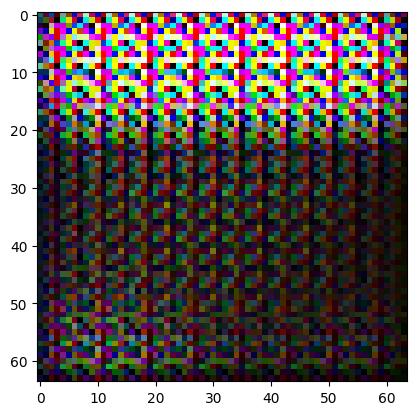

Generator loss:  tf.Tensor(1.0432594, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.96153116, shape=(), dtype=float32)



Training epoch: 2: 100%|██████████| 79/79 [00:13<00:00,  5.83it/s]


Generator loss:  tf.Tensor(1.1762909, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.1415017, shape=(), dtype=float32)



Training epoch: 3: 100%|██████████| 79/79 [00:14<00:00,  5.61it/s]


Generator loss:  tf.Tensor(1.0434668, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.0861795, shape=(), dtype=float32)



Training epoch: 4: 100%|██████████| 79/79 [00:14<00:00,  5.49it/s]


Generator loss:  tf.Tensor(1.3942716, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.255796, shape=(), dtype=float32)



Training epoch: 5: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


Generator loss:  tf.Tensor(1.0232096, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.2662042, shape=(), dtype=float32)



Training epoch: 6: 100%|██████████| 79/79 [00:15<00:00,  5.13it/s]


Generator loss:  tf.Tensor(1.0764402, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.4045413, shape=(), dtype=float32)



Training epoch: 7: 100%|██████████| 79/79 [00:15<00:00,  5.22it/s]


Generator loss:  tf.Tensor(1.2471546, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.99199444, shape=(), dtype=float32)



Training epoch: 8: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(1.3872491, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.0198458, shape=(), dtype=float32)



Training epoch: 9: 100%|██████████| 79/79 [00:14<00:00,  5.39it/s]


Generator loss:  tf.Tensor(2.5842714, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.5191263, shape=(), dtype=float32)



Training epoch: 10: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


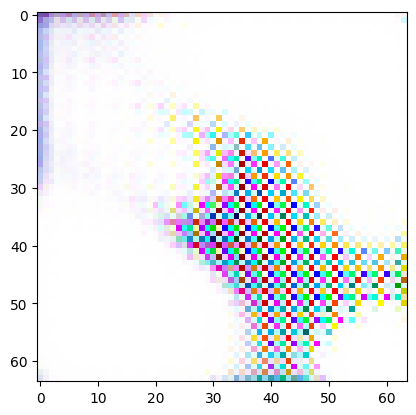

Generator loss:  tf.Tensor(1.7556183, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.1889166, shape=(), dtype=float32)



Training epoch: 11: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(1.5630444, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.76872265, shape=(), dtype=float32)



Training epoch: 12: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(2.201565, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.63699025, shape=(), dtype=float32)



Training epoch: 13: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(1.6528175, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.0616505, shape=(), dtype=float32)



Training epoch: 14: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(1.2578847, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.1923236, shape=(), dtype=float32)



Training epoch: 15: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(1.8369565, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.66106236, shape=(), dtype=float32)



Training epoch: 16: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(1.2769119, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.9475678, shape=(), dtype=float32)



Training epoch: 17: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(1.7955253, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.7515522, shape=(), dtype=float32)



Training epoch: 18: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(1.8967133, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.025585, shape=(), dtype=float32)



Training epoch: 19: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(1.1142422, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.1867752, shape=(), dtype=float32)



Training epoch: 20: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(2.8890946, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.3735557, shape=(), dtype=float32)



Training epoch: 21: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(2.782551, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.46303472, shape=(), dtype=float32)



Training epoch: 22: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


Generator loss:  tf.Tensor(1.9595604, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.89433956, shape=(), dtype=float32)



Training epoch: 23: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.7470148, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.34082255, shape=(), dtype=float32)



Training epoch: 24: 100%|██████████| 79/79 [00:15<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.488516, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.23934251, shape=(), dtype=float32)



Training epoch: 25: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.94463, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03778522, shape=(), dtype=float32)



Training epoch: 26: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(6.358063, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.063907236, shape=(), dtype=float32)



Training epoch: 27: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.8405874, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(1.0552694, shape=(), dtype=float32)



Training epoch: 28: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.8666806, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.26426497, shape=(), dtype=float32)



Training epoch: 29: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.840159, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.44367296, shape=(), dtype=float32)



Training epoch: 30: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.2955647, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.35443693, shape=(), dtype=float32)



Training epoch: 31: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.8337023, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.22190537, shape=(), dtype=float32)



Training epoch: 32: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.2155104, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10306899, shape=(), dtype=float32)



Training epoch: 33: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.8605902, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.4427919, shape=(), dtype=float32)



Training epoch: 34: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.080044, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.19744325, shape=(), dtype=float32)



Training epoch: 35: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.7670183, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.16666526, shape=(), dtype=float32)



Training epoch: 36: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(9.529055, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.5046745, shape=(), dtype=float32)



Training epoch: 37: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.0333617, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.42983004, shape=(), dtype=float32)



Training epoch: 38: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.7075546, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.29942033, shape=(), dtype=float32)



Training epoch: 39: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.851211, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.27549097, shape=(), dtype=float32)



Training epoch: 40: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5603, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.21205497, shape=(), dtype=float32)



Training epoch: 41: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.4349813, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.101951614, shape=(), dtype=float32)



Training epoch: 42: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.8322225, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.18686825, shape=(), dtype=float32)



Training epoch: 43: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(2.3509977, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.7195199, shape=(), dtype=float32)



Training epoch: 44: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(2.1931627, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.72753286, shape=(), dtype=float32)



Training epoch: 45: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(2.5369084, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.28542233, shape=(), dtype=float32)



Training epoch: 46: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(4.3609834, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.3946795, shape=(), dtype=float32)



Training epoch: 47: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(2.8036225, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.54790306, shape=(), dtype=float32)



Training epoch: 48: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(2.6506262, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.61694384, shape=(), dtype=float32)



Training epoch: 49: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


Generator loss:  tf.Tensor(2.9737663, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.28462446, shape=(), dtype=float32)



Training epoch: 50: 100%|██████████| 79/79 [00:15<00:00,  5.26it/s]


Generator loss:  tf.Tensor(2.2504501, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.6212665, shape=(), dtype=float32)



Training epoch: 51: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.3976843, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.31367207, shape=(), dtype=float32)



Training epoch: 52: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(2.9533045, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.29672548, shape=(), dtype=float32)



Training epoch: 53: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.3756588, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.24465662, shape=(), dtype=float32)



Training epoch: 54: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.0390308, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.4794766, shape=(), dtype=float32)



Training epoch: 55: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.0500963, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.33114097, shape=(), dtype=float32)



Training epoch: 56: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.5179682, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.25942284, shape=(), dtype=float32)



Training epoch: 57: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.0293746, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.40070057, shape=(), dtype=float32)



Training epoch: 58: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.6754715, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.22558106, shape=(), dtype=float32)



Training epoch: 59: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.118094, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.44636413, shape=(), dtype=float32)



Training epoch: 60: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.978683, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.28459096, shape=(), dtype=float32)



Training epoch: 61: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.5307665, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.41273624, shape=(), dtype=float32)



Training epoch: 62: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.6781137, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15072474, shape=(), dtype=float32)



Training epoch: 63: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.8929753, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.22589995, shape=(), dtype=float32)



Training epoch: 64: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.577381, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.20411542, shape=(), dtype=float32)



Training epoch: 65: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.8998768, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2636795, shape=(), dtype=float32)



Training epoch: 66: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.4161932, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.29216102, shape=(), dtype=float32)



Training epoch: 67: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.3831625, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2819379, shape=(), dtype=float32)



Training epoch: 68: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.5437055, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.3151917, shape=(), dtype=float32)



Training epoch: 69: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.0568144, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.26371938, shape=(), dtype=float32)



Training epoch: 70: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(2.7792323, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.32911217, shape=(), dtype=float32)



Training epoch: 71: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(2.4827642, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.61271095, shape=(), dtype=float32)



Training epoch: 72: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.1219838, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.36057553, shape=(), dtype=float32)



Training epoch: 73: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.4040015, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.3775311, shape=(), dtype=float32)



Training epoch: 74: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.9330409, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.24553224, shape=(), dtype=float32)



Training epoch: 75: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.059439, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.18276554, shape=(), dtype=float32)



Training epoch: 76: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.889157, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.19557358, shape=(), dtype=float32)



Training epoch: 77: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.943723, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.22297601, shape=(), dtype=float32)



Training epoch: 78: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(3.1686645, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.34440053, shape=(), dtype=float32)



Training epoch: 79: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(3.7751727, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.31369716, shape=(), dtype=float32)



Training epoch: 80: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.335641, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.40201178, shape=(), dtype=float32)



Training epoch: 81: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.8453116, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.21799834, shape=(), dtype=float32)



Training epoch: 82: 100%|██████████| 79/79 [00:14<00:00,  5.27it/s]


Generator loss:  tf.Tensor(4.894695, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2069084, shape=(), dtype=float32)



Training epoch: 83: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(5.008525, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15131249, shape=(), dtype=float32)



Training epoch: 84: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.5363493, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.17687947, shape=(), dtype=float32)



Training epoch: 85: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.2991805, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.17588748, shape=(), dtype=float32)



Training epoch: 86: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.0642776, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.23249571, shape=(), dtype=float32)



Training epoch: 87: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.4091542, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2525, shape=(), dtype=float32)



Training epoch: 88: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.9480727, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.20961568, shape=(), dtype=float32)



Training epoch: 89: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.8651216, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.28412223, shape=(), dtype=float32)



Training epoch: 90: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.1691036, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.24277924, shape=(), dtype=float32)



Training epoch: 91: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.041415, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2416019, shape=(), dtype=float32)



Training epoch: 92: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.920483, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.25329265, shape=(), dtype=float32)



Training epoch: 93: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.1776981, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.36444595, shape=(), dtype=float32)



Training epoch: 94: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.601559, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.19006258, shape=(), dtype=float32)



Training epoch: 95: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.2995455, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.27740768, shape=(), dtype=float32)



Training epoch: 96: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.0499725, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.24436013, shape=(), dtype=float32)



Training epoch: 97: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.858138, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.25014147, shape=(), dtype=float32)



Training epoch: 98: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.9945462, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2994363, shape=(), dtype=float32)



Training epoch: 99: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.0881002, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.32080922, shape=(), dtype=float32)



Training epoch: 100: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


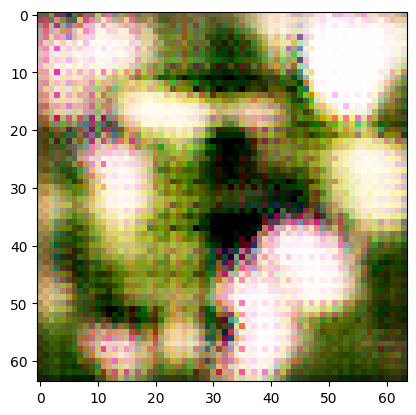

Generator loss:  tf.Tensor(3.4022515, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2289164, shape=(), dtype=float32)



Training epoch: 101: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(3.4444299, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.27021375, shape=(), dtype=float32)



Training epoch: 102: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.245406, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.21001625, shape=(), dtype=float32)



Training epoch: 103: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.378085, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13806352, shape=(), dtype=float32)



Training epoch: 104: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(3.768596, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.20558463, shape=(), dtype=float32)



Training epoch: 105: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.2354155, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.14314803, shape=(), dtype=float32)



Training epoch: 106: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.4026375, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.2127736, shape=(), dtype=float32)



Training epoch: 107: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.930087, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13508643, shape=(), dtype=float32)



Training epoch: 108: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.2828875, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11773648, shape=(), dtype=float32)



Training epoch: 109: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.178758, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13609418, shape=(), dtype=float32)



Training epoch: 110: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.2986836, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13480362, shape=(), dtype=float32)



Training epoch: 111: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.0094957, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.20373622, shape=(), dtype=float32)



Training epoch: 112: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.4913106, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1451207, shape=(), dtype=float32)



Training epoch: 113: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.7561383, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.18315385, shape=(), dtype=float32)



Training epoch: 114: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.3578815, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.104865074, shape=(), dtype=float32)



Training epoch: 115: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7457566, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.087896466, shape=(), dtype=float32)



Training epoch: 116: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.8785377, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.044300165, shape=(), dtype=float32)



Training epoch: 117: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.809778, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07145156, shape=(), dtype=float32)



Training epoch: 118: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.3975196, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.21229379, shape=(), dtype=float32)



Training epoch: 119: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.3135753, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11755786, shape=(), dtype=float32)



Training epoch: 120: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.710036, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15019315, shape=(), dtype=float32)



Training epoch: 121: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.8967192, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.17213862, shape=(), dtype=float32)



Training epoch: 122: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.9838576, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15372783, shape=(), dtype=float32)



Training epoch: 123: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.965954, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.18825024, shape=(), dtype=float32)



Training epoch: 124: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.9031816, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.16317132, shape=(), dtype=float32)



Training epoch: 125: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.280457, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11333286, shape=(), dtype=float32)



Training epoch: 126: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.71833, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.17606287, shape=(), dtype=float32)



Training epoch: 127: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.7475142, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.14941734, shape=(), dtype=float32)



Training epoch: 128: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(3.9712532, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15079653, shape=(), dtype=float32)



Training epoch: 129: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.277649, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12234801, shape=(), dtype=float32)



Training epoch: 130: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.0131164, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.21764895, shape=(), dtype=float32)



Training epoch: 131: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.9650977, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1753561, shape=(), dtype=float32)



Training epoch: 132: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.491244, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.113614105, shape=(), dtype=float32)



Training epoch: 133: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.963116, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.078170426, shape=(), dtype=float32)



Training epoch: 134: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.3189206, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09056358, shape=(), dtype=float32)



Training epoch: 135: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5188017, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09062731, shape=(), dtype=float32)



Training epoch: 136: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.745686, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1644976, shape=(), dtype=float32)



Training epoch: 137: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.111211, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.17859629, shape=(), dtype=float32)



Training epoch: 138: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(3.7880032, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.14963001, shape=(), dtype=float32)



Training epoch: 139: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.678358, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15925619, shape=(), dtype=float32)



Training epoch: 140: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.2062364, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.16443281, shape=(), dtype=float32)



Training epoch: 141: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.168298, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12964544, shape=(), dtype=float32)



Training epoch: 142: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.3160486, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13659157, shape=(), dtype=float32)



Training epoch: 143: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.071016, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13714132, shape=(), dtype=float32)



Training epoch: 144: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.0932403, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15355441, shape=(), dtype=float32)



Training epoch: 145: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.3105073, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.14897919, shape=(), dtype=float32)



Training epoch: 146: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.4115367, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1292035, shape=(), dtype=float32)



Training epoch: 147: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.911066, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11758506, shape=(), dtype=float32)



Training epoch: 148: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8529043, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.088914365, shape=(), dtype=float32)



Training epoch: 149: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(3.9408107, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.16625202, shape=(), dtype=float32)



Training epoch: 150: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.2198143, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11303984, shape=(), dtype=float32)



Training epoch: 151: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.960875, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09662914, shape=(), dtype=float32)



Training epoch: 152: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.1816177, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15770712, shape=(), dtype=float32)



Training epoch: 153: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(3.9495177, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13838321, shape=(), dtype=float32)



Training epoch: 154: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.316295, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15579905, shape=(), dtype=float32)



Training epoch: 155: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.568262, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.102513485, shape=(), dtype=float32)



Training epoch: 156: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.0982027, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.068445824, shape=(), dtype=float32)



Training epoch: 157: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6023946, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08329288, shape=(), dtype=float32)



Training epoch: 158: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.8356996, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15977259, shape=(), dtype=float32)



Training epoch: 159: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.621734, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09496354, shape=(), dtype=float32)



Training epoch: 160: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.721356, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12978195, shape=(), dtype=float32)



Training epoch: 161: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.2015257, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.091096036, shape=(), dtype=float32)



Training epoch: 162: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.814787, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09987055, shape=(), dtype=float32)



Training epoch: 163: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.1169047, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12992449, shape=(), dtype=float32)



Training epoch: 164: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.632567, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13852504, shape=(), dtype=float32)



Training epoch: 165: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.3926973, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.14096218, shape=(), dtype=float32)



Training epoch: 166: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.223586, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12392558, shape=(), dtype=float32)



Training epoch: 167: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.468192, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.091867395, shape=(), dtype=float32)



Training epoch: 168: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.4964137, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15142529, shape=(), dtype=float32)



Training epoch: 169: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.002953, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15090825, shape=(), dtype=float32)



Training epoch: 170: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.515542, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.124711506, shape=(), dtype=float32)



Training epoch: 171: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.2359495, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13841924, shape=(), dtype=float32)



Training epoch: 172: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.191341, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12847129, shape=(), dtype=float32)



Training epoch: 173: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.4949265, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12739971, shape=(), dtype=float32)



Training epoch: 174: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.084538, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13201448, shape=(), dtype=float32)



Training epoch: 175: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2255697, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12285928, shape=(), dtype=float32)



Training epoch: 176: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.449919, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12021018, shape=(), dtype=float32)



Training epoch: 177: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.950454, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13544078, shape=(), dtype=float32)



Training epoch: 178: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.382836, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05451584, shape=(), dtype=float32)



Training epoch: 179: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0533986, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06317048, shape=(), dtype=float32)



Training epoch: 180: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.085163, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.15442806, shape=(), dtype=float32)



Training epoch: 181: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.5428333, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07288071, shape=(), dtype=float32)



Training epoch: 182: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6143985, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.116581894, shape=(), dtype=float32)



Training epoch: 183: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.4080415, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12860098, shape=(), dtype=float32)



Training epoch: 184: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.7810426, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10494691, shape=(), dtype=float32)



Training epoch: 185: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.8977857, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0891533, shape=(), dtype=float32)



Training epoch: 186: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.926277, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0641212, shape=(), dtype=float32)



Training epoch: 187: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6918707, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0964895, shape=(), dtype=float32)



Training epoch: 188: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.4906526, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11396531, shape=(), dtype=float32)



Training epoch: 189: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.468644, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10220833, shape=(), dtype=float32)



Training epoch: 190: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.4418845, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09011112, shape=(), dtype=float32)



Training epoch: 191: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5158944, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10597737, shape=(), dtype=float32)



Training epoch: 192: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5081797, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.101228535, shape=(), dtype=float32)



Training epoch: 193: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.896365, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10094346, shape=(), dtype=float32)



Training epoch: 194: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.714694, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13553749, shape=(), dtype=float32)



Training epoch: 195: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.047311, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12794894, shape=(), dtype=float32)



Training epoch: 196: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.3990912, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08919286, shape=(), dtype=float32)



Training epoch: 197: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.5100465, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09424129, shape=(), dtype=float32)



Training epoch: 198: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.687705, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10279081, shape=(), dtype=float32)



Training epoch: 199: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.922694, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12473834, shape=(), dtype=float32)



Training epoch: 200: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.830605, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10492333, shape=(), dtype=float32)



Training epoch: 201: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.3377676, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11751809, shape=(), dtype=float32)



Training epoch: 202: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.546085, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1305052, shape=(), dtype=float32)



Training epoch: 203: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.5430913, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13215381, shape=(), dtype=float32)



Training epoch: 204: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.2281795, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09546718, shape=(), dtype=float32)



Training epoch: 205: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.3006854, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10347034, shape=(), dtype=float32)



Training epoch: 206: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.4252653, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.124196246, shape=(), dtype=float32)



Training epoch: 207: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.3719344, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11651387, shape=(), dtype=float32)



Training epoch: 208: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.4087048, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11300612, shape=(), dtype=float32)



Training epoch: 209: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.463055, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.085367516, shape=(), dtype=float32)



Training epoch: 210: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.418885, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08111395, shape=(), dtype=float32)



Training epoch: 211: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.8775992, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09943717, shape=(), dtype=float32)



Training epoch: 212: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.6388216, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12125393, shape=(), dtype=float32)



Training epoch: 213: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.0613046, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11621766, shape=(), dtype=float32)



Training epoch: 214: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.587257, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1121181, shape=(), dtype=float32)



Training epoch: 215: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.1554127, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09396639, shape=(), dtype=float32)



Training epoch: 216: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.620051, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13469659, shape=(), dtype=float32)



Training epoch: 217: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2486644, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0925482, shape=(), dtype=float32)



Training epoch: 218: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.841498, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.101689644, shape=(), dtype=float32)



Training epoch: 219: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.1610928, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13738765, shape=(), dtype=float32)



Training epoch: 220: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.1528006, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08949222, shape=(), dtype=float32)



Training epoch: 221: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1710763, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10091493, shape=(), dtype=float32)



Training epoch: 222: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6758924, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09782427, shape=(), dtype=float32)



Training epoch: 223: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.1963167, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10977069, shape=(), dtype=float32)



Training epoch: 224: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.3771415, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11214239, shape=(), dtype=float32)



Training epoch: 225: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.501154, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09341857, shape=(), dtype=float32)



Training epoch: 226: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.3562856, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.12005031, shape=(), dtype=float32)



Training epoch: 227: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.17497, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.113299, shape=(), dtype=float32)



Training epoch: 228: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.3268056, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.110485956, shape=(), dtype=float32)



Training epoch: 229: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.489273, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09439309, shape=(), dtype=float32)



Training epoch: 230: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.466078, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10962611, shape=(), dtype=float32)



Training epoch: 231: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.3898654, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10343048, shape=(), dtype=float32)



Training epoch: 232: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.437787, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09853285, shape=(), dtype=float32)



Training epoch: 233: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.897629, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1284247, shape=(), dtype=float32)



Training epoch: 234: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.3470764, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09964264, shape=(), dtype=float32)



Training epoch: 235: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.5790505, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.123591386, shape=(), dtype=float32)



Training epoch: 236: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.120733, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09480306, shape=(), dtype=float32)



Training epoch: 237: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2090545, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.101355046, shape=(), dtype=float32)



Training epoch: 238: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.096084, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09660589, shape=(), dtype=float32)



Training epoch: 239: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.744457, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11497159, shape=(), dtype=float32)



Training epoch: 240: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.475961, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07890572, shape=(), dtype=float32)



Training epoch: 241: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.47278, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.116807826, shape=(), dtype=float32)



Training epoch: 242: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.1492257, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09773183, shape=(), dtype=float32)



Training epoch: 243: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.664225, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.086572774, shape=(), dtype=float32)



Training epoch: 244: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.95194, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.097636044, shape=(), dtype=float32)



Training epoch: 245: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.874033, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09822683, shape=(), dtype=float32)



Training epoch: 246: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.416141, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08595375, shape=(), dtype=float32)



Training epoch: 247: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5223055, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09242133, shape=(), dtype=float32)



Training epoch: 248: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.5888295, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09007232, shape=(), dtype=float32)



Training epoch: 249: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.627597, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08424247, shape=(), dtype=float32)



Training epoch: 250: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.3820405, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.122374825, shape=(), dtype=float32)



Training epoch: 251: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.4152603, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.108348384, shape=(), dtype=float32)



Training epoch: 252: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.1092777, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09403525, shape=(), dtype=float32)



Training epoch: 253: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.8980618, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10708776, shape=(), dtype=float32)



Training epoch: 254: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2148676, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.097577855, shape=(), dtype=float32)



Training epoch: 255: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.359523, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.102640234, shape=(), dtype=float32)



Training epoch: 256: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6629, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09179775, shape=(), dtype=float32)



Training epoch: 257: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6121264, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08997051, shape=(), dtype=float32)



Training epoch: 258: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.4203725, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09928793, shape=(), dtype=float32)



Training epoch: 259: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.518291, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09962175, shape=(), dtype=float32)



Training epoch: 260: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.873107, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.079782374, shape=(), dtype=float32)



Training epoch: 261: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.5029764, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09907528, shape=(), dtype=float32)



Training epoch: 262: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7143993, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08238598, shape=(), dtype=float32)



Training epoch: 263: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.7503786, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09249745, shape=(), dtype=float32)



Training epoch: 264: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2941446, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0942436, shape=(), dtype=float32)



Training epoch: 265: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.4110646, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09511968, shape=(), dtype=float32)



Training epoch: 266: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.389067, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09085345, shape=(), dtype=float32)



Training epoch: 267: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.510632, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08915748, shape=(), dtype=float32)



Training epoch: 268: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.399355, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.090281226, shape=(), dtype=float32)



Training epoch: 269: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.528171, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.118317954, shape=(), dtype=float32)



Training epoch: 270: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.543477, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09001709, shape=(), dtype=float32)



Training epoch: 271: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7944775, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0981647, shape=(), dtype=float32)



Training epoch: 272: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.493419, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07797977, shape=(), dtype=float32)



Training epoch: 273: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.355157, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10264913, shape=(), dtype=float32)



Training epoch: 274: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0147004, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06261667, shape=(), dtype=float32)



Training epoch: 275: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.980479, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.071487315, shape=(), dtype=float32)



Training epoch: 276: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5524087, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09515357, shape=(), dtype=float32)



Training epoch: 277: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.427811, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.107488394, shape=(), dtype=float32)



Training epoch: 278: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.3769608, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08607926, shape=(), dtype=float32)



Training epoch: 279: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.551907, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08227772, shape=(), dtype=float32)



Training epoch: 280: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.6487393, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07047613, shape=(), dtype=float32)



Training epoch: 281: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.944173, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.090354204, shape=(), dtype=float32)



Training epoch: 282: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.804889, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07153385, shape=(), dtype=float32)



Training epoch: 283: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.8528934, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.081303425, shape=(), dtype=float32)



Training epoch: 284: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.7229013, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07269266, shape=(), dtype=float32)



Training epoch: 285: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.2484365, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.073480174, shape=(), dtype=float32)



Training epoch: 286: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.0709977, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.091733456, shape=(), dtype=float32)



Training epoch: 287: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.52948, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09781914, shape=(), dtype=float32)



Training epoch: 288: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.079509, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.087844536, shape=(), dtype=float32)



Training epoch: 289: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.3987546, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09642018, shape=(), dtype=float32)



Training epoch: 290: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.4682193, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08752786, shape=(), dtype=float32)



Training epoch: 291: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.5603957, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09254428, shape=(), dtype=float32)



Training epoch: 292: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.4732766, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.094358735, shape=(), dtype=float32)



Training epoch: 293: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.620208, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06660717, shape=(), dtype=float32)



Training epoch: 294: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.555771, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08165914, shape=(), dtype=float32)



Training epoch: 295: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.6086416, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07463006, shape=(), dtype=float32)



Training epoch: 296: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.620993, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.10790232, shape=(), dtype=float32)



Training epoch: 297: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.048746, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07784771, shape=(), dtype=float32)



Training epoch: 298: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.730984, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08491577, shape=(), dtype=float32)



Training epoch: 299: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9006786, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06844914, shape=(), dtype=float32)



Training epoch: 300: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.9932656, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.081898294, shape=(), dtype=float32)



Training epoch: 301: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.374621, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07412278, shape=(), dtype=float32)



Training epoch: 302: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.408768, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08676914, shape=(), dtype=float32)



Training epoch: 303: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.3740597, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08541091, shape=(), dtype=float32)



Training epoch: 304: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.826542, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.064109065, shape=(), dtype=float32)



Training epoch: 305: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.944801, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07399655, shape=(), dtype=float32)



Training epoch: 306: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.857842, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.085627735, shape=(), dtype=float32)



Training epoch: 307: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.4680605, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08529776, shape=(), dtype=float32)



Training epoch: 308: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.8619556, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08443312, shape=(), dtype=float32)



Training epoch: 309: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.5899906, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07565236, shape=(), dtype=float32)



Training epoch: 310: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.226953, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07614266, shape=(), dtype=float32)



Training epoch: 311: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.09524, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07377762, shape=(), dtype=float32)



Training epoch: 312: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.62542, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07592455, shape=(), dtype=float32)



Training epoch: 313: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.509207, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08950146, shape=(), dtype=float32)



Training epoch: 314: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1128373, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08506882, shape=(), dtype=float32)



Training epoch: 315: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.665182, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08377427, shape=(), dtype=float32)



Training epoch: 316: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.479016, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0779753, shape=(), dtype=float32)



Training epoch: 317: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.5522003, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07070979, shape=(), dtype=float32)



Training epoch: 318: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.4132586, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0824566, shape=(), dtype=float32)



Training epoch: 319: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.0666356, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.104305, shape=(), dtype=float32)



Training epoch: 320: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.594895, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.11315656, shape=(), dtype=float32)



Training epoch: 321: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.457655, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.087403744, shape=(), dtype=float32)



Training epoch: 322: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.1920366, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09081634, shape=(), dtype=float32)



Training epoch: 323: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.693544, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.074444555, shape=(), dtype=float32)



Training epoch: 324: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9797516, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08557344, shape=(), dtype=float32)



Training epoch: 325: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.1410494, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.093377575, shape=(), dtype=float32)



Training epoch: 326: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.2201133, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0895554, shape=(), dtype=float32)



Training epoch: 327: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.5085673, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07879767, shape=(), dtype=float32)



Training epoch: 328: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.954199, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0684585, shape=(), dtype=float32)



Training epoch: 329: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.09026, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06930357, shape=(), dtype=float32)



Training epoch: 330: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.4787126, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07746066, shape=(), dtype=float32)



Training epoch: 331: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5170236, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08917587, shape=(), dtype=float32)



Training epoch: 332: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.90305, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.079739146, shape=(), dtype=float32)



Training epoch: 333: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.9225926, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08029643, shape=(), dtype=float32)



Training epoch: 334: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.4592886, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08043073, shape=(), dtype=float32)



Training epoch: 335: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.71398, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.074897364, shape=(), dtype=float32)



Training epoch: 336: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6934257, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.075494274, shape=(), dtype=float32)



Training epoch: 337: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.3428807, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07539055, shape=(), dtype=float32)



Training epoch: 338: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.719477, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.069025, shape=(), dtype=float32)



Training epoch: 339: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.248925, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061687246, shape=(), dtype=float32)



Training epoch: 340: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.105427, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08594788, shape=(), dtype=float32)



Training epoch: 341: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.8774285, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08180741, shape=(), dtype=float32)



Training epoch: 342: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.711885, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.091467604, shape=(), dtype=float32)



Training epoch: 343: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.471332, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08727956, shape=(), dtype=float32)



Training epoch: 344: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.680176, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0623389, shape=(), dtype=float32)



Training epoch: 345: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.236665, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.1037087, shape=(), dtype=float32)



Training epoch: 346: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.3832273, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08458918, shape=(), dtype=float32)



Training epoch: 347: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.483285, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.082091935, shape=(), dtype=float32)



Training epoch: 348: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Generator loss:  tf.Tensor(4.618816, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07876029, shape=(), dtype=float32)



Training epoch: 349: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7144136, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061355397, shape=(), dtype=float32)



Training epoch: 350: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.954605, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07268052, shape=(), dtype=float32)



Training epoch: 351: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9960756, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.089231476, shape=(), dtype=float32)



Training epoch: 352: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.8797235, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06818299, shape=(), dtype=float32)



Training epoch: 353: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.7715764, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06447902, shape=(), dtype=float32)



Training epoch: 354: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7410426, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08661027, shape=(), dtype=float32)



Training epoch: 355: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.7480483, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0800821, shape=(), dtype=float32)



Training epoch: 356: 100%|██████████| 79/79 [00:14<00:00,  5.36it/s]


Generator loss:  tf.Tensor(4.865039, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09982167, shape=(), dtype=float32)



Training epoch: 357: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.7882776, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07980318, shape=(), dtype=float32)



Training epoch: 358: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.56338, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.079277374, shape=(), dtype=float32)



Training epoch: 359: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.600579, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0740506, shape=(), dtype=float32)



Training epoch: 360: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.4898868, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07923851, shape=(), dtype=float32)



Training epoch: 361: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.617114, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09210108, shape=(), dtype=float32)



Training epoch: 362: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.5603385, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06721845, shape=(), dtype=float32)



Training epoch: 363: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.146475, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08237998, shape=(), dtype=float32)



Training epoch: 364: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.558889, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.062037557, shape=(), dtype=float32)



Training epoch: 365: 100%|██████████| 79/79 [00:14<00:00,  5.28it/s]


Generator loss:  tf.Tensor(4.7603436, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08709346, shape=(), dtype=float32)



Training epoch: 366: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.5303974, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06639231, shape=(), dtype=float32)



Training epoch: 367: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.181659, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08607017, shape=(), dtype=float32)



Training epoch: 368: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.7241225, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07622784, shape=(), dtype=float32)



Training epoch: 369: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.767276, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.078481615, shape=(), dtype=float32)



Training epoch: 370: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.5947766, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07182326, shape=(), dtype=float32)



Training epoch: 371: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.8018217, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.069680125, shape=(), dtype=float32)



Training epoch: 372: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.501157, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07408161, shape=(), dtype=float32)



Training epoch: 373: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.772669, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06704487, shape=(), dtype=float32)



Training epoch: 374: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.0233555, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0650716, shape=(), dtype=float32)



Training epoch: 375: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.828771, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.069573686, shape=(), dtype=float32)



Training epoch: 376: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9688582, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.066466875, shape=(), dtype=float32)



Training epoch: 377: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.356368, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08490269, shape=(), dtype=float32)



Training epoch: 378: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9802012, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.064657815, shape=(), dtype=float32)



Training epoch: 379: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.845256, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.075511314, shape=(), dtype=float32)



Training epoch: 380: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.6826215, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07587742, shape=(), dtype=float32)



Training epoch: 381: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.608072, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07738071, shape=(), dtype=float32)



Training epoch: 382: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.4437323, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06496663, shape=(), dtype=float32)



Training epoch: 383: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6850677, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.077247, shape=(), dtype=float32)



Training epoch: 384: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.986726, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07228808, shape=(), dtype=float32)



Training epoch: 385: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8729234, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.073685825, shape=(), dtype=float32)



Training epoch: 386: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.649489, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.062231123, shape=(), dtype=float32)



Training epoch: 387: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7667103, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08280495, shape=(), dtype=float32)



Training epoch: 388: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.6488338, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06512661, shape=(), dtype=float32)



Training epoch: 389: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.035115, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.070673496, shape=(), dtype=float32)



Training epoch: 390: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.8062162, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07340814, shape=(), dtype=float32)



Training epoch: 391: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8779745, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.069957, shape=(), dtype=float32)



Training epoch: 392: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.3465443, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.111203566, shape=(), dtype=float32)



Training epoch: 393: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.570631, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09493802, shape=(), dtype=float32)



Training epoch: 394: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.920344, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.074380286, shape=(), dtype=float32)



Training epoch: 395: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0287504, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06982255, shape=(), dtype=float32)



Training epoch: 396: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.5678425, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.074439734, shape=(), dtype=float32)



Training epoch: 397: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.661834, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.09079611, shape=(), dtype=float32)



Training epoch: 398: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.7238717, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.072056405, shape=(), dtype=float32)



Training epoch: 399: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.717477, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06855931, shape=(), dtype=float32)



Training epoch: 400: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8078384, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07410727, shape=(), dtype=float32)



Training epoch: 401: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6083364, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06940747, shape=(), dtype=float32)



Training epoch: 402: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.825943, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06601488, shape=(), dtype=float32)



Training epoch: 403: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.7115417, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06863709, shape=(), dtype=float32)



Training epoch: 404: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.5903993, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07807668, shape=(), dtype=float32)



Training epoch: 405: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.558163, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.067118935, shape=(), dtype=float32)



Training epoch: 406: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.0151095, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06779682, shape=(), dtype=float32)



Training epoch: 407: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.8382893, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07282782, shape=(), dtype=float32)



Training epoch: 408: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8065944, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08124087, shape=(), dtype=float32)



Training epoch: 409: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(4.827483, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06678873, shape=(), dtype=float32)



Training epoch: 410: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.651027, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08325215, shape=(), dtype=float32)



Training epoch: 411: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7534847, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06904337, shape=(), dtype=float32)



Training epoch: 412: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6786366, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.049174502, shape=(), dtype=float32)



Training epoch: 413: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.7525187, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05699736, shape=(), dtype=float32)



Training epoch: 414: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.9108505, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05529506, shape=(), dtype=float32)



Training epoch: 415: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.4484053, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.070358485, shape=(), dtype=float32)



Training epoch: 416: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.853067, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.053598683, shape=(), dtype=float32)



Training epoch: 417: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.832541, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08290507, shape=(), dtype=float32)



Training epoch: 418: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9421186, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07495615, shape=(), dtype=float32)



Training epoch: 419: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.6843925, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06531247, shape=(), dtype=float32)



Training epoch: 420: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.7450614, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05298482, shape=(), dtype=float32)



Training epoch: 421: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.3131337, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.059857503, shape=(), dtype=float32)



Training epoch: 422: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.176728, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061317023, shape=(), dtype=float32)



Training epoch: 423: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.6475444, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05857359, shape=(), dtype=float32)



Training epoch: 424: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.50796, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.059483837, shape=(), dtype=float32)



Training epoch: 425: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.018723, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06473263, shape=(), dtype=float32)



Training epoch: 426: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.9407177, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.088920295, shape=(), dtype=float32)



Training epoch: 427: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.514557, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.091838546, shape=(), dtype=float32)



Training epoch: 428: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.60265, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06764542, shape=(), dtype=float32)



Training epoch: 429: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.804163, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06409623, shape=(), dtype=float32)



Training epoch: 430: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.2645144, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057496596, shape=(), dtype=float32)



Training epoch: 431: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.11635, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06908272, shape=(), dtype=float32)



Training epoch: 432: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.726827, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.062439267, shape=(), dtype=float32)



Training epoch: 433: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.1221647, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07113157, shape=(), dtype=float32)



Training epoch: 434: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.8752327, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057502832, shape=(), dtype=float32)



Training epoch: 435: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0271235, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07339167, shape=(), dtype=float32)



Training epoch: 436: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.6853876, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.069800645, shape=(), dtype=float32)



Training epoch: 437: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.018979, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.060151596, shape=(), dtype=float32)



Training epoch: 438: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.9477167, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.065955564, shape=(), dtype=float32)



Training epoch: 439: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.675003, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061849136, shape=(), dtype=float32)



Training epoch: 440: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.0410547, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.068703994, shape=(), dtype=float32)



Training epoch: 441: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.6423388, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.054895636, shape=(), dtype=float32)



Training epoch: 442: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.5370297, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.08658277, shape=(), dtype=float32)



Training epoch: 443: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.8609324, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05226906, shape=(), dtype=float32)



Training epoch: 444: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.0038085, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06248556, shape=(), dtype=float32)



Training epoch: 445: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.007156, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05583334, shape=(), dtype=float32)



Training epoch: 446: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.976585, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06388891, shape=(), dtype=float32)



Training epoch: 447: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.365414, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05235493, shape=(), dtype=float32)



Training epoch: 448: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.156039, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06671335, shape=(), dtype=float32)



Training epoch: 449: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.9086833, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.053646903, shape=(), dtype=float32)



Training epoch: 450: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.046125, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.055922978, shape=(), dtype=float32)



Training epoch: 451: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.883814, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05919978, shape=(), dtype=float32)



Training epoch: 452: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1848702, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.064930715, shape=(), dtype=float32)



Training epoch: 453: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.2675195, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.050901882, shape=(), dtype=float32)



Training epoch: 454: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.134703, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05300658, shape=(), dtype=float32)



Training epoch: 455: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.34332, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042998593, shape=(), dtype=float32)



Training epoch: 456: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.1246486, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05664543, shape=(), dtype=float32)



Training epoch: 457: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.9957232, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05237731, shape=(), dtype=float32)



Training epoch: 458: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.3994827, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.045294825, shape=(), dtype=float32)



Training epoch: 459: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.6906953, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.060122974, shape=(), dtype=float32)



Training epoch: 460: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.0734625, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05114237, shape=(), dtype=float32)



Training epoch: 461: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.335294, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.059055075, shape=(), dtype=float32)



Training epoch: 462: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.061424, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05740726, shape=(), dtype=float32)



Training epoch: 463: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.1105685, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057915457, shape=(), dtype=float32)



Training epoch: 464: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.31713, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.059068378, shape=(), dtype=float32)



Training epoch: 465: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.3228803, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.049477004, shape=(), dtype=float32)



Training epoch: 466: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.347943, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04654397, shape=(), dtype=float32)



Training epoch: 467: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.2085943, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07713523, shape=(), dtype=float32)



Training epoch: 468: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.734969, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052183792, shape=(), dtype=float32)



Training epoch: 469: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.3718786, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.058326323, shape=(), dtype=float32)



Training epoch: 470: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1551275, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037735756, shape=(), dtype=float32)



Training epoch: 471: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1354594, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.13486142, shape=(), dtype=float32)



Training epoch: 472: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.0199094, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061488315, shape=(), dtype=float32)



Training epoch: 473: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.4427643, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06696831, shape=(), dtype=float32)



Training epoch: 474: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.904407, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06551217, shape=(), dtype=float32)



Training epoch: 475: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.892915, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.064037554, shape=(), dtype=float32)



Training epoch: 476: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.966287, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.062600076, shape=(), dtype=float32)



Training epoch: 477: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8788095, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05987099, shape=(), dtype=float32)



Training epoch: 478: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.1914144, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06681735, shape=(), dtype=float32)



Training epoch: 479: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.770312, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06413083, shape=(), dtype=float32)



Training epoch: 480: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8582606, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.054054223, shape=(), dtype=float32)



Training epoch: 481: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.6859164, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05709426, shape=(), dtype=float32)



Training epoch: 482: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.6627846, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.068195246, shape=(), dtype=float32)



Training epoch: 483: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.042677, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06270588, shape=(), dtype=float32)



Training epoch: 484: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.188753, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.072840385, shape=(), dtype=float32)



Training epoch: 485: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.070809, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.061919816, shape=(), dtype=float32)



Training epoch: 486: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.079528, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06648945, shape=(), dtype=float32)



Training epoch: 487: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.2611113, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.053485908, shape=(), dtype=float32)



Training epoch: 488: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.1356025, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04580524, shape=(), dtype=float32)



Training epoch: 489: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.04142, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0562341, shape=(), dtype=float32)



Training epoch: 490: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.0822268, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057136487, shape=(), dtype=float32)



Training epoch: 491: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.3063507, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.065572746, shape=(), dtype=float32)



Training epoch: 492: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.8887315, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03618518, shape=(), dtype=float32)



Training epoch: 493: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.891773, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.055807903, shape=(), dtype=float32)



Training epoch: 494: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.1552277, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.049315833, shape=(), dtype=float32)



Training epoch: 495: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.2056074, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06854704, shape=(), dtype=float32)



Training epoch: 496: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(4.877866, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.055063013, shape=(), dtype=float32)



Training epoch: 497: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.7621694, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.054974362, shape=(), dtype=float32)



Training epoch: 498: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.0679507, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05085868, shape=(), dtype=float32)



Training epoch: 499: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.291773, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07031452, shape=(), dtype=float32)



Training epoch: 500: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


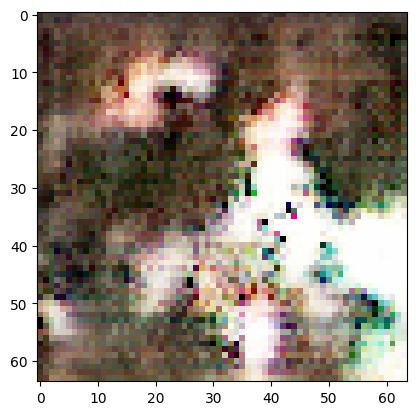

Generator loss:  tf.Tensor(4.6308007, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.07193974, shape=(), dtype=float32)



Training epoch: 501: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(4.912141, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.059095297, shape=(), dtype=float32)



Training epoch: 502: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.393932, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05946944, shape=(), dtype=float32)



Training epoch: 503: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.0339255, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05200719, shape=(), dtype=float32)



Training epoch: 504: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.506446, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04838385, shape=(), dtype=float32)



Training epoch: 505: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.102572, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06040878, shape=(), dtype=float32)



Training epoch: 506: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.0400443, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06221758, shape=(), dtype=float32)



Training epoch: 507: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0217233, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.062044155, shape=(), dtype=float32)



Training epoch: 508: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9902935, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.051473707, shape=(), dtype=float32)



Training epoch: 509: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.49651, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06050758, shape=(), dtype=float32)



Training epoch: 510: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.976018, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.060110804, shape=(), dtype=float32)



Training epoch: 511: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(4.8539734, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06159691, shape=(), dtype=float32)



Training epoch: 512: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.1426744, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04104341, shape=(), dtype=float32)



Training epoch: 513: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.480648, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.048459053, shape=(), dtype=float32)



Training epoch: 514: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(4.8942175, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057741806, shape=(), dtype=float32)



Training epoch: 515: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.217543, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.050984412, shape=(), dtype=float32)



Training epoch: 516: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.516629, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05724024, shape=(), dtype=float32)



Training epoch: 517: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.8667135, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052837227, shape=(), dtype=float32)



Training epoch: 518: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.529269, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052948084, shape=(), dtype=float32)



Training epoch: 519: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.233239, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05638114, shape=(), dtype=float32)



Training epoch: 520: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.204095, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05004775, shape=(), dtype=float32)



Training epoch: 521: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.2691007, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04529347, shape=(), dtype=float32)



Training epoch: 522: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.508037, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.058846243, shape=(), dtype=float32)



Training epoch: 523: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(4.900256, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04508431, shape=(), dtype=float32)



Training epoch: 524: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.38343, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.057115, shape=(), dtype=float32)



Training epoch: 525: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6765833, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.058049735, shape=(), dtype=float32)



Training epoch: 526: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6277733, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.032449964, shape=(), dtype=float32)



Training epoch: 527: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.000876, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.049134865, shape=(), dtype=float32)



Training epoch: 528: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.314684, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.044162963, shape=(), dtype=float32)



Training epoch: 529: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.4133883, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052632544, shape=(), dtype=float32)



Training epoch: 530: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.087198, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06023658, shape=(), dtype=float32)



Training epoch: 531: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.1049795, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052277748, shape=(), dtype=float32)



Training epoch: 532: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.234629, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052525286, shape=(), dtype=float32)



Training epoch: 533: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.271587, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042224456, shape=(), dtype=float32)



Training epoch: 534: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8726716, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.055186007, shape=(), dtype=float32)



Training epoch: 535: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.118936, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.048234217, shape=(), dtype=float32)



Training epoch: 536: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.3528676, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04914707, shape=(), dtype=float32)



Training epoch: 537: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.5532146, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05623334, shape=(), dtype=float32)



Training epoch: 538: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.1475816, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.045624893, shape=(), dtype=float32)



Training epoch: 539: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.277965, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042521566, shape=(), dtype=float32)



Training epoch: 540: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.3157606, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04704058, shape=(), dtype=float32)



Training epoch: 541: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.917059, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04743168, shape=(), dtype=float32)



Training epoch: 542: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(4.9947376, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034899116, shape=(), dtype=float32)



Training epoch: 543: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.0572248, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.051781613, shape=(), dtype=float32)



Training epoch: 544: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.248222, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.038285635, shape=(), dtype=float32)



Training epoch: 545: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.6787972, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03151422, shape=(), dtype=float32)



Training epoch: 546: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.370024, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.047318164, shape=(), dtype=float32)



Training epoch: 547: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.495054, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.063878424, shape=(), dtype=float32)



Training epoch: 548: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.4173045, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.043290567, shape=(), dtype=float32)



Training epoch: 549: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.3117194, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.050253224, shape=(), dtype=float32)



Training epoch: 550: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.403432, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04114471, shape=(), dtype=float32)



Training epoch: 551: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.6999297, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.041908365, shape=(), dtype=float32)



Training epoch: 552: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.844569, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.06031127, shape=(), dtype=float32)



Training epoch: 553: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.126006, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.047616933, shape=(), dtype=float32)



Training epoch: 554: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.3122067, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04034957, shape=(), dtype=float32)



Training epoch: 555: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.454907, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.043314174, shape=(), dtype=float32)



Training epoch: 556: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.325004, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034441352, shape=(), dtype=float32)



Training epoch: 557: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.648446, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034066577, shape=(), dtype=float32)



Training epoch: 558: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.619398, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.038791012, shape=(), dtype=float32)



Training epoch: 559: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.953433, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036539312, shape=(), dtype=float32)



Training epoch: 560: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.816637, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037352163, shape=(), dtype=float32)



Training epoch: 561: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.404552, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.046750538, shape=(), dtype=float32)



Training epoch: 562: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.674473, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037314434, shape=(), dtype=float32)



Training epoch: 563: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.5901113, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.046524443, shape=(), dtype=float32)



Training epoch: 564: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.5182705, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.033852197, shape=(), dtype=float32)



Training epoch: 565: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.2650905, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04188019, shape=(), dtype=float32)



Training epoch: 566: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.695246, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036286313, shape=(), dtype=float32)



Training epoch: 567: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.32777, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.029380128, shape=(), dtype=float32)



Training epoch: 568: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.302484, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04895133, shape=(), dtype=float32)



Training epoch: 569: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.2556376, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04887652, shape=(), dtype=float32)



Training epoch: 570: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(7.000462, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036156215, shape=(), dtype=float32)



Training epoch: 571: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.4461255, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04193413, shape=(), dtype=float32)



Training epoch: 572: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.7438927, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04538377, shape=(), dtype=float32)



Training epoch: 573: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.668208, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05518171, shape=(), dtype=float32)



Training epoch: 574: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.0740757, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.047249824, shape=(), dtype=float32)



Training epoch: 575: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.61029, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.043316435, shape=(), dtype=float32)



Training epoch: 576: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.3494263, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.038846172, shape=(), dtype=float32)



Training epoch: 577: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.5200057, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03673895, shape=(), dtype=float32)



Training epoch: 578: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.9122753, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04266901, shape=(), dtype=float32)



Training epoch: 579: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.5376043, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0381891, shape=(), dtype=float32)



Training epoch: 580: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.395637, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04593732, shape=(), dtype=float32)



Training epoch: 581: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.394107, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04148981, shape=(), dtype=float32)



Training epoch: 582: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.8976436, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.046145998, shape=(), dtype=float32)



Training epoch: 583: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.436254, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035741806, shape=(), dtype=float32)



Training epoch: 584: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(6.476228, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.032445602, shape=(), dtype=float32)



Training epoch: 585: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.47455, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052470848, shape=(), dtype=float32)



Training epoch: 586: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.7893314, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.041470848, shape=(), dtype=float32)



Training epoch: 587: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.4767914, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03250697, shape=(), dtype=float32)



Training epoch: 588: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.273843, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037153587, shape=(), dtype=float32)



Training epoch: 589: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6565566, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04066435, shape=(), dtype=float32)



Training epoch: 590: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.945371, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03645554, shape=(), dtype=float32)



Training epoch: 591: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.78962, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.039253224, shape=(), dtype=float32)



Training epoch: 592: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.441293, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035759468, shape=(), dtype=float32)



Training epoch: 593: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.723645, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04710639, shape=(), dtype=float32)



Training epoch: 594: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.0683036, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04730448, shape=(), dtype=float32)



Training epoch: 595: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6362925, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.046187576, shape=(), dtype=float32)



Training epoch: 596: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.556188, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028398033, shape=(), dtype=float32)



Training epoch: 597: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6366353, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03455021, shape=(), dtype=float32)



Training epoch: 598: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.518533, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035289105, shape=(), dtype=float32)



Training epoch: 599: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.1996884, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.045986097, shape=(), dtype=float32)



Training epoch: 600: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.780323, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03588861, shape=(), dtype=float32)



Training epoch: 601: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.752628, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042519316, shape=(), dtype=float32)



Training epoch: 602: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.512387, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03742645, shape=(), dtype=float32)



Training epoch: 603: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.812263, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042613517, shape=(), dtype=float32)



Training epoch: 604: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6356177, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0396724, shape=(), dtype=float32)



Training epoch: 605: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.1612926, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04111937, shape=(), dtype=float32)



Training epoch: 606: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6883755, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.05384872, shape=(), dtype=float32)



Training epoch: 607: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.6545835, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.030893525, shape=(), dtype=float32)



Training epoch: 608: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.629629, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03463388, shape=(), dtype=float32)



Training epoch: 609: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.9065075, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.040565167, shape=(), dtype=float32)



Training epoch: 610: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.1534624, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.039941844, shape=(), dtype=float32)



Training epoch: 611: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.430116, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042694513, shape=(), dtype=float32)



Training epoch: 612: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6090426, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037454147, shape=(), dtype=float32)



Training epoch: 613: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6421847, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03838168, shape=(), dtype=float32)



Training epoch: 614: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.7986813, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.025518175, shape=(), dtype=float32)



Training epoch: 615: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.1537533, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0386336, shape=(), dtype=float32)



Training epoch: 616: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.7146273, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02722311, shape=(), dtype=float32)



Training epoch: 617: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.0824933, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.040139362, shape=(), dtype=float32)



Training epoch: 618: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.333878, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.038016185, shape=(), dtype=float32)



Training epoch: 619: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6697845, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031289704, shape=(), dtype=float32)



Training epoch: 620: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.057695, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03352414, shape=(), dtype=float32)



Training epoch: 621: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.5838475, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052918315, shape=(), dtype=float32)



Training epoch: 622: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.127998, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028755844, shape=(), dtype=float32)



Training epoch: 623: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.698292, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02880461, shape=(), dtype=float32)



Training epoch: 624: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(6.1647677, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03199364, shape=(), dtype=float32)



Training epoch: 625: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.1683497, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035563976, shape=(), dtype=float32)



Training epoch: 626: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.5619507, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03251647, shape=(), dtype=float32)



Training epoch: 627: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.927915, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04250227, shape=(), dtype=float32)



Training epoch: 628: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.296395, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034220435, shape=(), dtype=float32)



Training epoch: 629: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.923522, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.032016557, shape=(), dtype=float32)



Training epoch: 630: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8339467, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03903884, shape=(), dtype=float32)



Training epoch: 631: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.049338, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034146857, shape=(), dtype=float32)



Training epoch: 632: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.5218034, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.023911718, shape=(), dtype=float32)



Training epoch: 633: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.5339494, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.044888392, shape=(), dtype=float32)



Training epoch: 634: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.8559103, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04385453, shape=(), dtype=float32)



Training epoch: 635: 100%|██████████| 79/79 [00:14<00:00,  5.29it/s]


Generator loss:  tf.Tensor(5.5593657, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.040821988, shape=(), dtype=float32)



Training epoch: 636: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.756478, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037363306, shape=(), dtype=float32)



Training epoch: 637: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(5.793003, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037346978, shape=(), dtype=float32)



Training epoch: 638: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.334559, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031764347, shape=(), dtype=float32)



Training epoch: 639: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.357268, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036342945, shape=(), dtype=float32)



Training epoch: 640: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(6.0860004, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.056858692, shape=(), dtype=float32)



Training epoch: 641: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.563823, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0344944, shape=(), dtype=float32)



Training epoch: 642: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.7248626, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.025312783, shape=(), dtype=float32)



Training epoch: 643: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(6.3692636, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.042699955, shape=(), dtype=float32)



Training epoch: 644: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.323304, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03261963, shape=(), dtype=float32)



Training epoch: 645: 100%|██████████| 79/79 [00:14<00:00,  5.30it/s]


Generator loss:  tf.Tensor(6.2242765, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026577795, shape=(), dtype=float32)



Training epoch: 646: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.569101, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034487113, shape=(), dtype=float32)



Training epoch: 647: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.17438, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034272645, shape=(), dtype=float32)



Training epoch: 648: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.7859025, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02934218, shape=(), dtype=float32)



Training epoch: 649: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8835087, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.027920412, shape=(), dtype=float32)



Training epoch: 650: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.698179, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024956036, shape=(), dtype=float32)



Training epoch: 651: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.8349633, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.038395345, shape=(), dtype=float32)



Training epoch: 652: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6412272, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02938978, shape=(), dtype=float32)



Training epoch: 653: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.9431386, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04108033, shape=(), dtype=float32)



Training epoch: 654: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.766411, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.0271246, shape=(), dtype=float32)



Training epoch: 655: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.670869, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04051152, shape=(), dtype=float32)



Training epoch: 656: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.1027155, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036893565, shape=(), dtype=float32)



Training epoch: 657: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.8615513, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02908243, shape=(), dtype=float32)



Training epoch: 658: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.878222, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03429202, shape=(), dtype=float32)



Training epoch: 659: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6772733, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034622192, shape=(), dtype=float32)



Training epoch: 660: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.9818516, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03538668, shape=(), dtype=float32)



Training epoch: 661: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(7.009158, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031964783, shape=(), dtype=float32)



Training epoch: 662: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.3630843, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024896782, shape=(), dtype=float32)



Training epoch: 663: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(7.2522297, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.048903618, shape=(), dtype=float32)



Training epoch: 664: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.4099984, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.030970855, shape=(), dtype=float32)



Training epoch: 665: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.2861705, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037322108, shape=(), dtype=float32)



Training epoch: 666: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.890107, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026620718, shape=(), dtype=float32)



Training epoch: 667: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(5.9097624, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03551671, shape=(), dtype=float32)



Training epoch: 668: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.9706945, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03646074, shape=(), dtype=float32)



Training epoch: 669: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8898215, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04244345, shape=(), dtype=float32)



Training epoch: 670: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.53337, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.049953274, shape=(), dtype=float32)



Training epoch: 671: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6419926, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.039261173, shape=(), dtype=float32)



Training epoch: 672: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.8218555, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02804202, shape=(), dtype=float32)



Training epoch: 673: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.2516494, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036515404, shape=(), dtype=float32)



Training epoch: 674: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.1491427, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034918834, shape=(), dtype=float32)



Training epoch: 675: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.975562, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.037180178, shape=(), dtype=float32)



Training epoch: 676: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.5400324, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.048650935, shape=(), dtype=float32)



Training epoch: 677: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.522538, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.032331806, shape=(), dtype=float32)



Training epoch: 678: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.5037646, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.052686594, shape=(), dtype=float32)



Training epoch: 679: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8788056, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03691672, shape=(), dtype=float32)



Training epoch: 680: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.834305, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03355506, shape=(), dtype=float32)



Training epoch: 681: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.2154493, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03084269, shape=(), dtype=float32)



Training epoch: 682: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(6.223265, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028087951, shape=(), dtype=float32)



Training epoch: 683: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.7873025, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034052506, shape=(), dtype=float32)



Training epoch: 684: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.634718, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03593307, shape=(), dtype=float32)



Training epoch: 685: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.6953034, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.039044935, shape=(), dtype=float32)



Training epoch: 686: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.6886606, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035303213, shape=(), dtype=float32)



Training epoch: 687: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.771828, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031366553, shape=(), dtype=float32)



Training epoch: 688: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.901993, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026143342, shape=(), dtype=float32)



Training epoch: 689: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.49716, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03194408, shape=(), dtype=float32)



Training epoch: 690: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.9938426, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03326752, shape=(), dtype=float32)



Training epoch: 691: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.0279226, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03267513, shape=(), dtype=float32)



Training epoch: 692: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.6468472, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.022523612, shape=(), dtype=float32)



Training epoch: 693: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.0194263, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02795686, shape=(), dtype=float32)



Training epoch: 694: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.505854, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.04073572, shape=(), dtype=float32)



Training epoch: 695: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.46881, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02676307, shape=(), dtype=float32)



Training epoch: 696: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.7878714, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.025578758, shape=(), dtype=float32)



Training epoch: 697: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.8470206, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.023337213, shape=(), dtype=float32)



Training epoch: 698: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.231798, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026531244, shape=(), dtype=float32)



Training epoch: 699: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.342262, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024499802, shape=(), dtype=float32)



Training epoch: 700: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.4213696, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031634524, shape=(), dtype=float32)



Training epoch: 701: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.213333, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02685057, shape=(), dtype=float32)



Training epoch: 702: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.4294744, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.025820648, shape=(), dtype=float32)



Training epoch: 703: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.4613276, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028920047, shape=(), dtype=float32)



Training epoch: 704: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.711116, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03135423, shape=(), dtype=float32)



Training epoch: 705: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(5.8111906, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034799453, shape=(), dtype=float32)



Training epoch: 706: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.123357, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.019459924, shape=(), dtype=float32)



Training epoch: 707: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.612544, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028689332, shape=(), dtype=float32)



Training epoch: 708: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.5753694, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028487273, shape=(), dtype=float32)



Training epoch: 709: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.861769, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.027052669, shape=(), dtype=float32)



Training epoch: 710: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.3593917, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024916487, shape=(), dtype=float32)



Training epoch: 711: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.7739444, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.025281725, shape=(), dtype=float32)



Training epoch: 712: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.235048, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031571016, shape=(), dtype=float32)



Training epoch: 713: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.0531015, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024518613, shape=(), dtype=float32)



Training epoch: 714: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.296937, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.022918653, shape=(), dtype=float32)



Training epoch: 715: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.330466, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.021574365, shape=(), dtype=float32)



Training epoch: 716: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.359014, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.022897612, shape=(), dtype=float32)



Training epoch: 717: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.348563, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031861972, shape=(), dtype=float32)



Training epoch: 718: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.41642, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03816539, shape=(), dtype=float32)



Training epoch: 719: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.384962, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026663147, shape=(), dtype=float32)



Training epoch: 720: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.253604, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.046284128, shape=(), dtype=float32)



Training epoch: 721: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.8007984, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02766387, shape=(), dtype=float32)



Training epoch: 722: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.48051, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.030141296, shape=(), dtype=float32)



Training epoch: 723: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(7.36822, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.022361085, shape=(), dtype=float32)



Training epoch: 724: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.142119, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.021808032, shape=(), dtype=float32)



Training epoch: 725: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.1865716, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02671543, shape=(), dtype=float32)



Training epoch: 726: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.5030828, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.020178456, shape=(), dtype=float32)



Training epoch: 727: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.48697, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.035175335, shape=(), dtype=float32)



Training epoch: 728: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(6.0770626, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028298408, shape=(), dtype=float32)



Training epoch: 729: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.35371, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026776517, shape=(), dtype=float32)



Training epoch: 730: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.484075, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028407633, shape=(), dtype=float32)



Training epoch: 731: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.1655955, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.020847589, shape=(), dtype=float32)



Training epoch: 732: 100%|██████████| 79/79 [00:14<00:00,  5.35it/s]


Generator loss:  tf.Tensor(6.5622883, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026905604, shape=(), dtype=float32)



Training epoch: 733: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.48439, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028116183, shape=(), dtype=float32)



Training epoch: 734: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.5026903, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.032957703, shape=(), dtype=float32)



Training epoch: 735: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.08561, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.030498514, shape=(), dtype=float32)



Training epoch: 736: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(6.152186, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028687792, shape=(), dtype=float32)



Training epoch: 737: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(5.898958, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.026685663, shape=(), dtype=float32)



Training epoch: 738: 100%|██████████| 79/79 [00:14<00:00,  5.31it/s]


Generator loss:  tf.Tensor(6.737617, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031645223, shape=(), dtype=float32)



Training epoch: 739: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.368096, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.036459405, shape=(), dtype=float32)



Training epoch: 740: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(5.7132034, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02431657, shape=(), dtype=float32)



Training epoch: 741: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.58304, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.031937677, shape=(), dtype=float32)



Training epoch: 742: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.419852, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.023944398, shape=(), dtype=float32)



Training epoch: 743: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.8466806, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.03155364, shape=(), dtype=float32)



Training epoch: 744: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.0262113, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.034677185, shape=(), dtype=float32)



Training epoch: 745: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.658655, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.024208287, shape=(), dtype=float32)



Training epoch: 746: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.4533367, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.028957056, shape=(), dtype=float32)



Training epoch: 747: 100%|██████████| 79/79 [00:14<00:00,  5.32it/s]


Generator loss:  tf.Tensor(5.999458, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02055974, shape=(), dtype=float32)



Training epoch: 748: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


Generator loss:  tf.Tensor(6.5614004, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.02808201, shape=(), dtype=float32)



Training epoch: 749: 100%|██████████| 79/79 [00:14<00:00,  5.34it/s]


Generator loss:  tf.Tensor(6.362721, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.019573195, shape=(), dtype=float32)



Training epoch: 750: 100%|██████████| 79/79 [00:14<00:00,  5.33it/s]


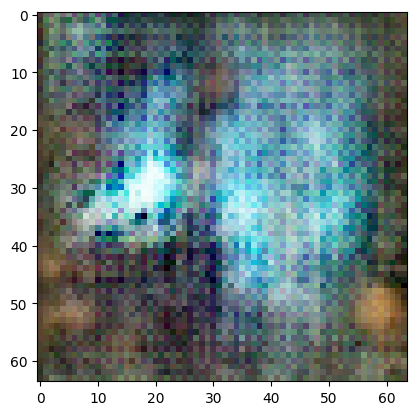

Generator loss:  tf.Tensor(6.906827, shape=(), dtype=float32)
Discriminator loss:  tf.Tensor(0.030353405, shape=(), dtype=float32)



In [11]:
checkpoints = [1, 10, 100, 500, 750]
def train(epochs):
    for epoch in range(epochs):
        gen_loss = []
        disc_loss = []
        for image_batch in tqdm(final_ds, desc=f"Training epoch: {epoch+1}"):
            gl, dl = train_step(image_batch)
            gen_loss.append(gl)
            disc_loss.append(dl)
        
        if (epoch+1) in checkpoints:
            out = generator(tf.random.normal([1, LATENT_DIM]))
            plt.imshow(out[0])
            plt.show()
        print("Generator loss: ", tf.reduce_mean(gen_loss))
        print("Discriminator loss: ", tf.reduce_mean(disc_loss))
        print()

train(750)
generator.save("generator.h5")